In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

In [35]:
# Dataset
data = pd.read_csv("daily-minimum-temperatures-in-me.csv")
df = pd.DataFrame(data)

df = pd.DataFrame(data)
print(df.head())

       Date  Temp Unnamed: 2
0  1/1/1981  20.7        NaN
1  1/2/1981  17.9        NaN
2  1/3/1981  18.8        NaN
3  1/4/1981  14.6        NaN
4  1/5/1981  15.8        NaN


In [34]:
# Baca ulang CSV dari awal, skip baris yang rusak
df = pd.read_csv(
    "daily-minimum-temperatures-in-me.csv",
    sep=",",
    on_bad_lines="skip",
    engine="python"
)

# Ambil kolom penting aja
df = df[['Date', 'Temp']]

# Hapus baris kosong & baris terakhir kalau bukan angka
df = df.dropna(subset=['Date', 'Temp'])

# Buang baris yang bukan tanggal (cek jika ada teks di kolom Date)
df = df[df['Date'].str.match(r'\d+/\d+/\d+', na=False)]

# Konversi ke datetime dengan deteksi otomatis
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')

# Hapus baris yang gagal dikonversi
df = df.dropna(subset=['Date'])

# Cek hasil
print(df.tail())
print(df.info())


           Date  Temp
3645 1990-12-27    14
3646 1990-12-28  13.6
3647 1990-12-29  13.5
3648 1990-12-30  15.7
3649 1990-12-31    13
<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3650 non-null   datetime64[ns]
 1   Temp    3650 non-null   object        
dtypes: datetime64[ns](1), object(1)
memory usage: 85.5+ KB
None


C:\Users\asus\AppData\Local\Temp\ipykernel_6540\3140580672.py:19: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True, errors='coerce')


In [39]:
# Pastikan kolom 'Temp' berisi string semua dulu
df['Temp'] = df['Temp'].astype(str)

# Hapus karakter non-numerik (kayak '?')
df['Temp'] = df['Temp'].str.replace('[^0-9.-]', '', regex=True)

# Ubah kembali ke float
df['Temp'] = pd.to_numeric(df['Temp'], errors='coerce')

# Hapus baris yang kosong / gagal dikonversi
df = df.dropna(subset=['Temp'])

# Pastikan semua angka valid
print(df['Temp'].head(10))
print(df['Temp'].dtype)


0    20.7
1    17.9
2    18.8
3    14.6
4    15.8
5    15.8
6    15.8
7    17.4
8    21.8
9    20.0
Name: Temp, dtype: float64
float64


In [40]:
temp_data = df['Temp'].values.reshape(-1,1)

In [41]:
# Normalisasi Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(temp_data)

In [42]:
# Membuat Data Sekuensial (Windowing)
timesteps = 60
x = []
y = []

for i in range(timesteps, len(scaled_data)):
    x.append(scaled_data[i-timesteps:i, 0])
    y.append(scaled_data[i, 0])

x, y = np.array(x), np.array(y)

# Reshape data ke format 3D yang dibutuhkan LSTM
x = np.reshape(x, (x.shape[0], x.shape[1], 1))


In [43]:
# Membangun Arsitektur Model LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile Model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

c:\KULIAH\MATA KULIAH SEMESTER 5\PEMBELAJARAN MESIN\TA4 LSTM\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

In [44]:
# Kita akan gunakan sebagian besar data untuk melatih
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Melatih Model
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0231 - val_loss: 0.0101
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0132 - val_loss: 0.0099
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0133 - val_loss: 0.0101
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0123 - val_loss: 0.0100
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0122 - val_loss: 0.0096
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0118 - val_loss: 0.0094
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0119 - val_loss: 0.0092
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0116 - val_loss: 0.0091
Epoch 9/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0113 - val_loss: 0.0092
Epoch 10/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0115 - val_loss: 0.0087
Epoch 11/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 12/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


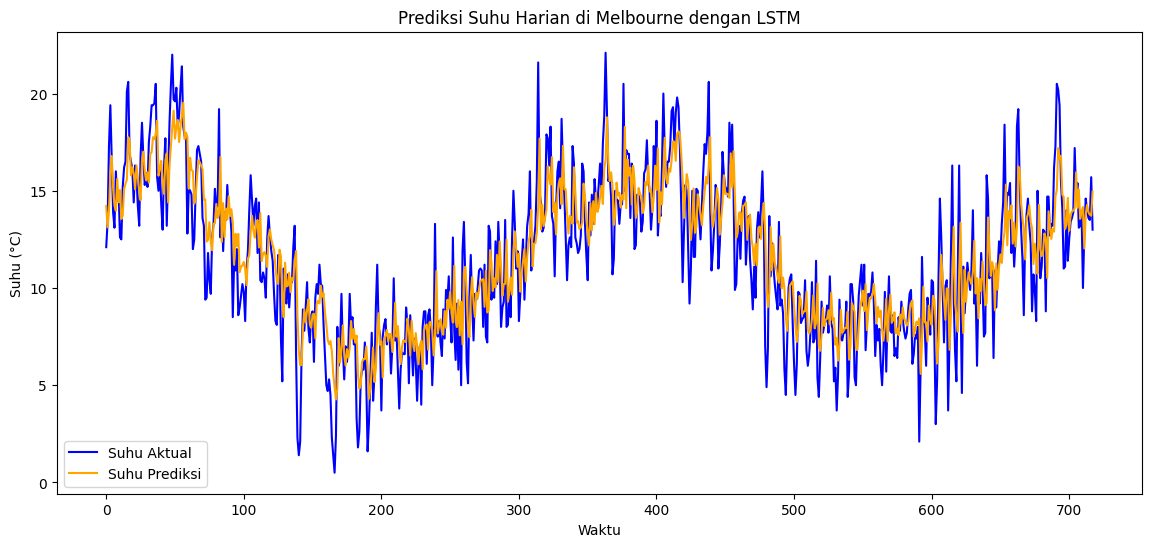

In [45]:
# Lakukan Prediksi
predictions = model.predict(x_test)

# kembalikan data ke skala aslinya
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisasi
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, color='blue', label='Suhu Aktual')
plt.plot(predictions, color='orange', label='Suhu Prediksi')
plt.title('Prediksi Suhu Harian di Melbourne dengan LSTM')
plt.xlabel('Waktu')
plt.ylabel('Suhu (°C)')
plt.legend()
plt.show()

In [49]:
# 'y_test_actual' = nilai suhu asli setelah di-inverse (hasil sebenarnya)
# 'predictions'   = hasil prediksi model setelah di-inverse (hasil prediksi)

# MSE (Mean Squared Error)
mse = mean_squared_error(y_test_actual, predictions)

# RMSE (Root Mean Squared Error)
rmse = np.sqrt(mse)

print(f"Nilai Root Mean Squared Error (RMSE): {rmse:.2f}")


Nilai Root Mean Squared Error (RMSE): 2.23


In [52]:
# Simpan model ke file .h5
model.save('model_lstm_suhu.h5')
print("✅ Model berhasil disimpan ke file 'model_lstm_suhu.h5'")

✅ Model berhasil disimpan ke file 'model_lstm_suhu.h5'
